<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/D_QNN_Genomic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512551 sha256=d05bc6050e613e3a1b5e69029c8850a0bf5a9763c33df5bcdc4eb502a2e0f539
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d5

In [3]:
!pip install genomic-benchmarks

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.5 MB/s eta 0:00:00
  Created wheel for genomic-benchmarks: filename=genomic_benchmarks-0.0.9-py3-none-any.whl size=22507 sha256=c16d9702970c72843c27b5b59ef14c97d764f10d82d21c354a59eb6d4a2cb780
  Stored in directory: /root/.cache/pip/wheels/86/78/72/de9d75be800b6d679b8814b9663b3f610c34188b443b8b9b77
Successfully built genomic-benchmarks


Updated code with identified improvements

update the model's parameters incrementally rather than reinitializing them. The learning rate can be updated in between iterations, but the internal model parameters should persist across iterations.

Modifications for Refining Internal Parameters Over Iterations
Persist Weights Across Iterations: Ensure that the model carries over the weights from one iteration to the next instead of resetting them. The NeuralNetworkClassifier should continue training from the existing state.

Avoid Reinitializing the Model: Instead of resetting the model with each fit call, you'll allow the optimizer (SPSA) to continue updating the weights based on the previous state.

Update v3

current version of your code, the learning rate update is based only on the gradient of the objective function and does not take into account the current parameter values (model weights). The learning rate adjustment is applied heuristically, based on the behavior of the objective function gradient (e.g., 0.95 decay if plateauing, 1.05 increase if improving), but it doesn't incorporate the actual state of the model parameters (weights).

In [4]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)
print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the test set: {len(train_set)}")
from collections import defaultdict
import numpy as np


# Filter out sequences that consist entirely of "N"
filtered_data_set = [sample for sample in data_set if not all(base == 'N' for base in sample[0])]

print(f"Filtered data set size: {len(filtered_data_set)}")
print("One sample from the filtered data set:")
print(filtered_data_set[0])

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in filtered_data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1


print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)

import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]

np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]


from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensionality of the scaled data
pca = PCA(n_components=2)  # Reduce to 2 components; adjust this number as needed
sequences_pca = pca.fit_transform(sequences_scaled)

# Update the sequences in np_data_set with the PCA-transformed sequences
for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_pca[i]

# Shuffle the dataset again after transformation
np.random.shuffle(np_data_set)

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

np_train_data = np_data_set[:500]
np_test_data = np_data_set[-50:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

# Extract the PCA-transformed sequences and labels
train_sequences = np.array([data_point["sequence"] for data_point in np_train_data])
train_labels = np.array([data_point["label"] for data_point in np_train_data])

test_sequences = np.array([data_point["sequence"] for data_point in np_test_data])
test_labels = np.array([data_point["label"] for data_point in np_test_data])

print(f"Shape of reduced train_sequences: {train_sequences.shape}")
print(f"Shape of reduced test_sequences: {test_sequences.shape}")


/usr/local/lib/python3.10/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Downloading...
From (original): https://drive.google.com/uc?id=1JW0-eTB-rJXvFcglqBo3pFZi1kyIWC3X
From (redirected): https://drive.google.com/uc?id=1JW0-eTB-rJXvFcglqBo3pFZi1kyIWC3X&confirm=t&uuid=d2361084-ad55-4575-bfbb-4da948f0a2cd
To: /root/.genomic_benchmarks/demo_human_or_worm.zip
100%|██████████| 28.9M/28.9M [00:00<00:00, 74.5MB/s]


Nuber of samples in the test set: 25000
Nuber of samples in the test set: 75000
Filtered data set size: 73118
One sample from the filtered data set:
('AACTGGAGGCAAAAAGAATATGCCCCTCCAATCACACAAATACGCCCATACCTGGGCCCCAGCTCATCCTCACTTCTCCAGACGAAGTCGCCAAACTTTTCATAGTGAGAGTTGTAGTGGTGCTGGACTCGGAACAGCATCGAGGCTGAGACCTCCATCAGTGTGTTGTAGGCCATCTGCTGCTCCTTTCCACTTGTGTA', 0)

First 5 samples in the word_combinations dict.
AACTGGAGGCAAAAAGAATATGCCCCTCCAATCACACAAA 1
ACTGGAGGCAAAAAGAATATGCCCCTCCAATCACACAAAT 2
CTGGAGGCAAAAAGAATATGCCCCTCCAATCACACAAATA 3
TGGAGGCAAAAAGAATATGCCCCTCCAATCACACAAATAC 4
GGAGGCAAAAAGAATATGCCCCTCCAATCACACAAATACG 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:
Length of np_train_data: 500
Length of np_test_data: 50
Shape of reduced train_sequences: (500, 2)
Shape of reduced test_sequences: (50, 2)


In [5]:
# Setup feature map and ansatz for VQC
num_features = train_sequences.shape[1]
##feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

from sklearn.preprocessing import MinMaxScaler

#features = MinMaxScaler().fit_transform(num_features)
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
data_train, data_test, data_train_labels, data_test_labels  = train_test_split(
    train_sequences, train_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

<ipython-input-8-d471da1b0212>:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


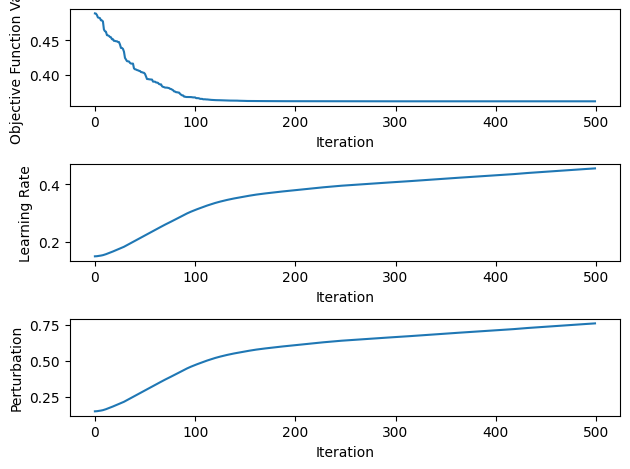

Trained parameters after iteration 10: [ 0.47742456  1.56640165 -0.60648329 -0.06167841  0.27771998  0.46156827
 -0.43739381  0.30796992  1.22900966  0.7636778 ]
Iteration 10 - Training Accuracy: 79.50%
Iteration 10 - Test Accuracy: 83.00%
Final Training Accuracy: 79.50%
Final Test Accuracy: 83.00%
Total Training Time: 1583.80 seconds


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output
from qiskit_algorithms.optimizers import SPSA

from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals


# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally

# Split into train and test
#data_train, data_test, data_train_labels, data_test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


# Variables to track objective function and learning rate
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for smoother learning rate adjustments
gradient_moving_avg = 0  # Moving average of gradients
initial_params = np.random.rand(RealAmplitudes(data_train.shape[1], reps=4).num_parameters)  # Initialize params


# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Create QNN circuit
qc = QNNCircuit(num_qubits=feature_dim, ansatz=ansatz, feature_map=prep)

# Parity function to interpret QNN output
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2

# Define the Sampler QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None):
    global gradient_moving_avg, learning_rates, perturbations

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    # Visualization of learning rate and perturbation
    plt.title("Objective Function, Learning Rate, and Perturbation")
    plt.subplot(3, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(3, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.subplot(3, 1, 3)
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.plot(range(len(perturbations)), perturbations)

    plt.tight_layout()
    plt.show()

# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.15, initial_perturbation=0.15, lr_alpha=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
    maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

# Define the neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=spsa_optimizer,
    loss='squared_error',
    initial_point=initial_params,  # Initialize with the starting parameters
)

import csv
# Prepare to save results in a CSV file
csv_file = "training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"])

train_accuracies = []
test_accuracies = []

# Deep Unfolding with multiple iterations
# Continue training with learned weights and adjust learning rate based on performance and gradients.
total_time = 0
current_params = initial_params  # Start with the initial parameters

for i in range(10):  # Deep unfolding iterations
    print(f"Deep Unfolding Iteration {i+1}/10")

    # Train the model with the current parameters
    start_time = time.time()
    sampler_classifier.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    # After training, retrieve the updated parameters from the optimizer
    current_params = sampler_classifier.weights
    print(f"Trained parameters after iteration {i+1}: {current_params}")

    # Store final weights and learning rate for next round
    final_learning_rate = learning_rates[-1]
    final_perturbation = perturbations[-1]

    # Evaluate the model performance
    train_accuracy = sampler_classifier.score(data_train, data_train_labels)
    test_accuracy = sampler_classifier.score(data_test, data_test_labels)

    # Log performance
    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    # Store accuracies for future reference
    # Store accuracies for future reference
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Write the results to the CSV file
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])


    # Update the learning rate for the next iteration based on gradients from SPSA
    spsa_optimizer.learning_rate = learning_rates[-1]
    sampler_classifier.initial_point = current_params

# Print final results
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")


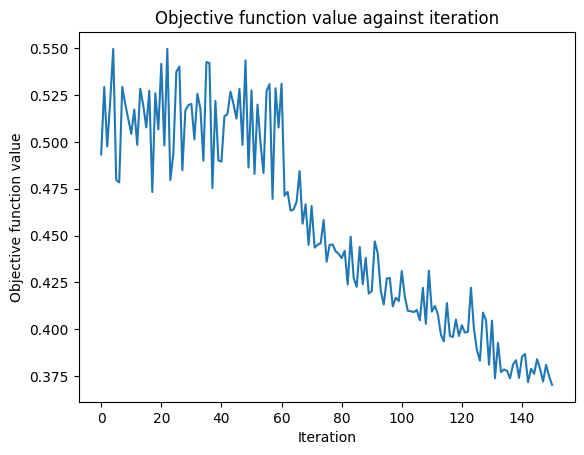

Training Accuracy: 70.75%
Test Accuracy: 75.00%
Total Training Time: 174.57 seconds
Results saved to training_results.csv


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output

from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals


# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

qc= QNNCircuit(num_qubits=feature_dim ,ansatz = ansatz, feature_map=prep)
# itr=0
# def training_callback(weights, obj_func_eval):
#         global itr
#         itr += 1
#         print(f"{itr} {obj_func_eval}", end=' | ')
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

sampler_qnn = SamplerQNN(
    circuit = qc,
    interpret=parity,
    output_shape=output_shape,
    # input_gradients= True
)

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=SPSA(maxiter=50), loss= 'squared_error',callback=callback_graph
)


total_time = 0
start_time = time.time()
sampler_classifier.fit(data_train, data_train_labels)
end_time = time.time()
epoch_time = end_time - start_time
total_time += epoch_time

test_accuracies=[]
train_accuracies=[]
# Evaluate the classifier
train_accuracy = sampler_classifier.score(data_train, data_train_labels)
test_accuracy = sampler_classifier.score(data_test, data_test_labels)

import csv
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)

# Print the results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")

# Save the results to a CSV file
csv_file = "training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy"])

    for i in range(len(objective_func_vals)):
        writer.writerow([i+1, objective_func_vals[i], train_accuracies[-1] * 100, test_accuracies[-1] * 100])

print(f"Results saved to {csv_file}")